[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

Measuring the **similarity** among different images is important for several reasons. For instance, image noise can be detected or a more diverse train-validation-test splitting can be achieved in order to estimate the real model's generalization.

In this notebook, we evaluate different metrics for measuring the similarity between different images and the same image with noise.

In [1]:
!pip install sewar

  Created wheel for sewar: filename=sewar-0.4.4-py3-none-any.whl size=10390 sha256=5cbebca5f3f2edd6858871e225213ee595eacf7d9a1022fd270d93d8a859a61d
  Stored in directory: /home/beast/.cache/pip/wheels/b5/00/df/f1ba40d0d44c95b0db52804e518c128d5631866b91ea1960ba
Successfully built sewar


In [14]:
import warnings
warnings.filterwarnings("ignore")

from sewar.full_ref import mse, uqi, ssim
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

from numpy import expand_dims
from skimage.util import random_noise

In [31]:
def plot_images(original, original_noisy, different):
    plt.figure(figsize=(18,8))
    plt.subplot(1, 3, 1)
    adv_diff = uqi(original, original)
    mse_diff = mse(original, original)
    title = f"Original -> MSE: {str(round(mse_diff, 4))}, UQI: {str(round(adv_diff, 4))}" 
    plt.title(title)
    plt.imshow(original)
    plt.axis("off")
    plt.subplot(1, 3, 2)
    adv_diff = uqi(original, original_noisy)
    mse_diff = mse(original, original_noisy)
    title = f"Noisy Original -> MSE: {str(round(mse_diff, 4))}, UQI: {str(round(adv_diff, 4))}" 
    plt.title(title)
    plt.imshow(original_noisy)
    plt.axis("off")
    plt.subplot(1, 3, 3)
    adv_diff = uqi(original, different)
    mse_diff = mse(original, different)
    title = f"Different Image -> MSE: {str(round(mse_diff, 4))}, UQI: {str(round(adv_diff, 4))}" 
    plt.title(title)
    plt.imshow(different)
    plt.axis("off")
    plt.show()

def read_data(path_list, im_size=224):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []

    # Exctract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                im = cv2.resize(im, (im_size, im_size), interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print(e)
                #print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)
    idx2tag = {v: k for k, v in tag2idx.items()}

    return X, y, idx2tag

In [33]:
IM_SIZE = 512
RANDOM_STATE = 2022
BASE_PATH = "eden_library_datasets" + os.path.sep

# Datasets' paths we want to work on.
PATH_LIST = [
    BASE_PATH + "Orange_tree-Citrus_sinensis-Phyllocnistis_citrella-PRX-RGB-NA-20200928-20210225103226/images"
]

In [34]:
i = 0
for path in PATH_LIST:
    # Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path))
    i += 1
x, y, idx2tag = read_data(PATH_LIST, IM_SIZE)

100%|██████████| 61/61 [00:07<00:00,  8.30it/s]


In [39]:
original = x[0]
original_noisy = np.array(random_noise(original, mode='s&p',amount=0.2)*255, dtype=np.uint8)
different = x[58]

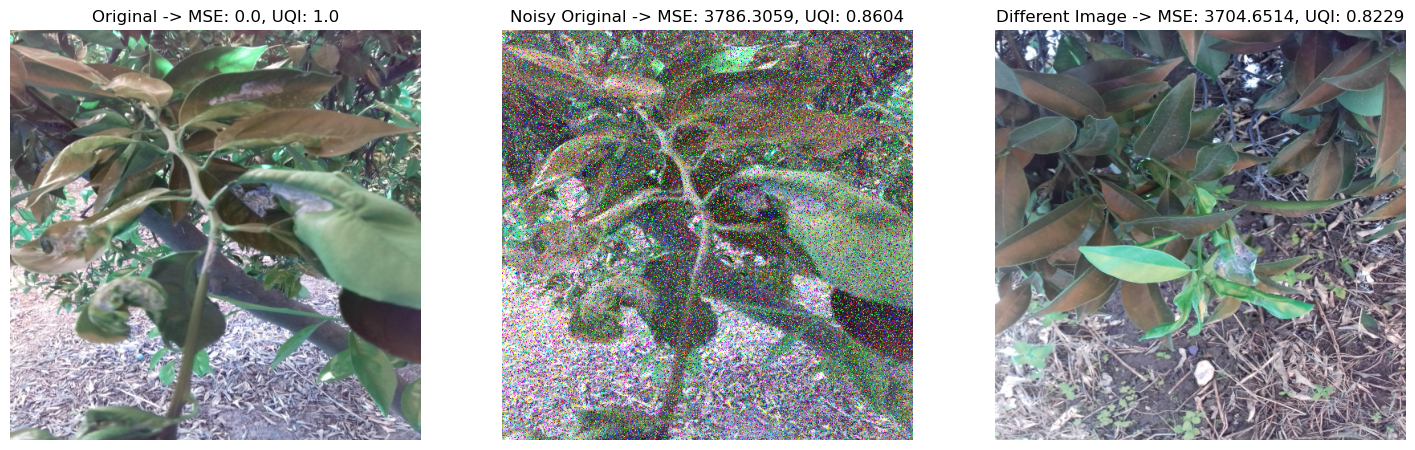

In [40]:
plot_images(original, original_noisy, different)

## Conclusions
In this example, UQI performed more robustly than MSE.

## Possible Extensions
1. Use different metrics (for instance, RMSE os SSIM).
2. Use different types of noise (blurring or Gaussian noise).
3. Try a different dataset.

## Bibliography

https://towardsdatascience.com/measuring-similarity-in-two-images-using-python-b72233eb53c6

https://betterprogramming.pub/how-to-measure-image-similarities-in-python-12f1cb2b7281